In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

In [2]:
# np.log10(22/14)

In [3]:
################################################################################
################################# READING DATA #################################
################################################################################
dir_name = os.getcwd() #+ '/saved_data/data_001'

fln = dir_name + '/Kolmogorov_Re40.0_T25000.0_dt0.01_N24.h5'
# fln = dir_name + '/Kolmogorov_Re30.0_T25000.0_dt0.01_N16.h5'

In [4]:
with h5py.File(fln, 'r') as f:
    t_recorded_samples = np.array(f['t'])
    snapshot_idx = int(t_recorded_samples.shape[0] / 2)
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))

    D = np.array(f['Dissipation'])

    # u_ref = np.array(f['u_reference'])
    # u_mean = np.sum(u_ref, axis=0) / u_ref.shape[0]
    # u_snapshot = u_ref[snapshot_idx].copy()
    # del(u_ref)
    # v_ref = np.array(f['v_reference'])
    # v_mean = np.sum(v_ref, axis=0) / v_ref.shape[0]
    # v_snapshot = v_ref[snapshot_idx].copy()
    # del(v_ref)
    # vort_ref = np.array(f['vort_reference'])
    # vort_mean = np.sum(vort_ref, axis=0) / vort_ref.shape[0]
    # vort_snapshot = vort_ref[snapshot_idx].copy()
    # del(vort_ref)
    
    uh = np.empty(shape=(len(t_recorded_samples), 2*N+1, 2*N+1), dtype=np.complex128)
    uh[:, :, N:] = np.array(f['uh'])
    uh[:, 0:N, 0:N] = np.conjugate(uh[:, N+1:, N+1:][:, ::-1, ::-1])
    uh[:, N+1:, 0:N] = np.conjugate(uh[:, 0:N, N+1:][:, ::-1, ::-1])
    # uh = np.array(f['uh'])
    # print(uh.shape)
    
    vh = np.empty(shape=(len(t_recorded_samples), 2*N+1, 2*N+1), dtype=np.complex128)
    vh[:, :, N:] = np.array(f['vh'])
    vh[:, 0:N, 0:N] = np.conjugate(vh[:, N+1:, N+1:][:, ::-1, ::-1])
    vh[:, N+1:, 0:N] = np.conjugate(vh[:, 0:N, N+1:][:, ::-1, ::-1])
    
    
    # u_mean_org = np.mean(u, axis=0) # np.sum(u, axis=0) / u.shape[0]
    # v = np.array(f['v'])
    # v_mean_org = np.mean(v, axis=0) # np.sum(v, axis=0) / v.shape[0]

T = t_recorded_samples[-1]

# print('mean(u**2) : {}'.format(np.mean(u**2)))
# print('mean(v**2) : {}'.format(np.mean(v**2)))

# print('mean(u_mean_org**2) : {}'.format(np.mean(u_mean_org**2)))
# print('mean(v_mean_org**2) : {}'.format(np.mean(v_mean_org**2)))

24 <class 'int'>


In [5]:
################################################################################
######################## COMPUTING REQUIRED QUANTITIES #########################
################################################################################

### computing KE
# u_prime = u - u_mean_org
# v_prime = v - v_mean_org

# print('mean(u_prime**2) : {}'.format(np.mean(u_prime**2)))
# print('mean(v_prime**2) : {}'.format(np.mean(v_prime**2)))

# K = np.mean(0.5*(u_prime**2 + v_prime**2), axis=-1) # TKE
# K = 0.5*np.mean(K, axis=-1)

# uh = np.fft.fftshift(np.fft.fft2(u_prime))
# # del(u_prime)
# del(u)
# vh = np.fft.fftshift(np.fft.fft2(v_prime))
# # del(v_prime)
# del(v)
def aap(f1, f2):
    # anti-aliased product
    N = int(0.5*(f1.shape[-1]-1))
    ndim = f1.ndim
    assert ndim < 4, 'input dimensions is greater than 3.'
    if ndim == 2:
        # f1_h, f2_h = np.expand_dims(f1, axis=0).copy(), np.expand_dims(f2, axis=0).copy()
        f1_h, f2_h = np.expand_dims(f1.copy(), axis=0), np.expand_dims(f2.copy(), axis=0)
    elif ndim == 3:
        f1_h, f2_h = f1.copy(), f2.copy()
    
    sz2 = 4*N + 1
    ff1_h = np.zeros((f1_h.shape[0], sz2, sz2), dtype=np.complex128)
    ff2_h = np.zeros((f2_h.shape[0], sz2, sz2), dtype=np.complex128)

    idx1, idx2 = N, 3*N + 1
    ff1_h[:, idx1:idx2, idx1:idx2] = f1_h
    ff2_h[:, idx1:idx2, idx1:idx2] = f2_h

    ff1 = np.fft.irfft2(np.fft.ifftshift(ff1_h), s=ff1_h.shape[-2:])
    ff2 = np.fft.irfft2(np.fft.ifftshift(ff2_h), s=ff2_h.shape[-2:])          # must take real part or use irfft2

    pp_h = (sz2/f1.shape[-1])**2 * np.fft.fft2(ff1*ff2)
    pp_h = np.fft.fftshift(pp_h)

    p_h = pp_h[:, idx1:idx2, idx1:idx2]

    if ndim == 2:
        p_h = p_h[0,:,:]

    return p_h

# Ehat = 0.5 * (aap(uh, uh) + aap(vh, vh))
# # Ehat = 0.5 * (np.abs(uh)**2 + np.abs(vh)**2)
# # Ehat = 0.5*np.fft.fftshift(np.fft.fft2(u_prime**2 + v_prime**2))
# Ehat_mean_abs = np.mean(np.abs(Ehat), axis=0)
# del(Ehat)

Ehat = 0.5 * (np.abs(uh)**2 + np.abs(vh)**2)

In [6]:
Ehat_mean_abs = np.mean(np.abs(Ehat), axis=0)
del(Ehat)

In [7]:
N = int(0.5*(uh.shape[-1]-1))
domain_len = 2*np.pi

dk = 2*np.pi / domain_len
n = np.arange(-N, N+1) # *dk

nn1, nn2 = np.meshgrid(n, n)
nn = nn1**2 + nn2**2

num_n = 1 + int( np.round((N**2 + N**2)**0.5) )
energy_spectrum = np.zeros(shape=num_n)
bool_arr = np.zeros(shape=num_n, dtype=np.bool_)
print(bool_arr)
num_elems = 1
for i in range(2*N+1):
    for j in range(2*N+1):
        e = Ehat_mean_abs[i, j]
        idx = int( np.round(nn[i, j]**0.5) )
        energy_spectrum[idx] += e
        bool_arr[idx] = True
print(bool_arr)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]


In [8]:
# for i in range(len(k)):
#     for j in range(len(k)):
#         e = Ehat_mean_abs[i, j]
#         idx = np.where(energy_spec_kk == kk[i, j])[0]
#         if len(idx) > 1:
#             print(i, j, idx)
#         energy_spectrum[idx] += e

In [9]:
# energy_spec_kk[[61, 85]]
# kk[2, 11]

In [10]:
Ehat_mean_abs[N, N]

0.0

In [11]:
uh[:, N, N]

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [12]:
vh[:, N, N]

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [13]:
# idx_sort = np.argsort(energy_spec_kk)
# energy_spec_kk = energy_spec_kk[idx_sort]**0.5
# energy_spectrum = energy_spectrum[idx_sort]

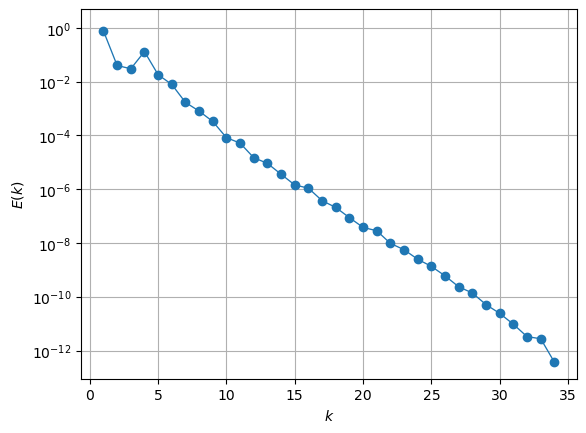

In [17]:
# kfit1 = 10
# kfit2 = 18

# temp = np.abs(energy_spec_kk - kfit1)
# idx1 = np.where(temp == np.min(temp))[0][0]
# temp = np.abs(energy_spec_kk - kfit2)
# idx2 = np.where(temp == np.min(temp))[0][0]

# coeffs = np.polyfit(np.log10(energy_spec_kk[idx1:idx2+1]), np.log10(energy_spectrum[idx1:idx2+1]), deg=1)
# a = coeffs[0]
# b = coeffs[1]

# xplot = np.linspace(5.5, 25, 100)
# yplot = (10**b) * (xplot**a)

# plt.loglog(energy_spec_kk, energy_spectrum, label='_nolegend_', linewidth=0.8)
# plt.loglog(xplot, yplot, '--', color='r', label='slope = {:.3f}'.format(a))
xEhat_plot = np.arange(num_n)[1:]
yEhat_plot = energy_spectrum[1:] / np.sum(energy_spectrum)
# yEhat_plot = Ehat_mean_abs[N+1:, N]
plt.semilogy(xEhat_plot, yEhat_plot, '-', marker='o', label='_nolegend_', linewidth=0.95)
plt.grid(True)
# plt.legend()
plt.xlabel(r'$k$')
plt.ylabel(r'$E(k)$')
plt.ylim(None, 5.)
# plt.xlim(None, 25)
# plt.savefig(fln[0:-3]+'-energy_spec-NEW.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
np.sum(energy_spectrum)

409818.5022494977

In [20]:
np.sum(energy_spectrum)

2819884.3934555748

In [19]:
energy_spectrum[0]

0.0